# Classification des courbes de Béziers

#### Importation des données des courbes

In [55]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import seaborn as sns

In [56]:
df = pd.read_csv('data.txt', sep=' ')

In [57]:
df.head(5)

,x1,y1,x2,y2,x3,y3,angle1
0,0,0,76,67,67,0,40.950627
1,0,0,10,152,73,0,26.276755
2,0,0,70,17,138,0,152.313337
3,0,0,94,180,169,0,50.194429
4,0,0,42,146,72,0,27.660491


In [58]:
def distance(x1, y1, x2, y2) -> float:
    return math.hypot(x2 - x1, y2 - y1)

def get_angle(points) -> float:
    ba = points[0] - points[1]
    bc = points[2] - points[1]
    cosine_angle = (ba @ bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def draw(points, difficulty) -> None:
    Path = mpath.Path
    fig, ctx = plt.subplots()

    pp1 = mpatches.PathPatch(
        Path([points[0], points[1], points[2]],
             [Path.MOVETO, Path.CURVE3, Path.CURVE3]),
        fc="none", transform=ctx.transData, linestyle="solid", linewidth=4, alpha=.5, color="#32a852")

    # Define lines over the control point
    ctx.plot([points[0][0], points[1][0]], [points[0][1],
                                            points[1][1]], dashes=[6, 2], color="#427852")
    ctx.plot([points[2][0], points[1][0]], [points[2][1],
                                            points[1][1]], dashes=[6, 2], color="#427852")

    # points
    ctx.plot(points[2][0], points[2][1], marker=".",
             markersize=16, color="#427852", clip_on=False)
    ctx.plot(points[1][0], points[1][1], marker=".",
             markersize=16, color="#0096b0", clip_on=False)
    ctx.plot(points[0][0], points[0][1], marker=".",
             markersize=16, color="#427852", clip_on=False)

    # Curve
    ctx.add_patch(pp1)

    title = "Difficulty : " + str(difficulty)
    # Title
    ctx.set_title(title)

    plt.xlim(0, 200)
    plt.ylim(0, 200)

    plt.show()
    plt.close()

In [59]:
# point 1 ==> np.array([a[0], a[1]])
# point 2 ==> np.array([a[2], a[3]]) (control point)
# point 3 ==> np.array([a[4], a[5]])
df["angle2"] = [get_angle([np.array([row[4], row[5]]), np.array([row[0], row[1]]), np.array([row[2], row[3]])])
                for row in df.itertuples(index=False)]

df["angle3"] = [180 - row[7] - row[6] 
                for row in df.itertuples(index=False)]

df["dist1"] = [distance(row[0], row[1], row[2], row[3])
               for row in df.itertuples(index=False)]

df["dist2"] = [distance(row[4], row[5], row[2], row[3])
               for row in df.itertuples(index=False)]

df.head(5)

,x1,y1,x2,y2,x3,y3,angle1,angle2,angle3,dist1,dist2
0,0,0,76,67,67,0,40.950627,41.398722,97.650651,101.316336,67.601775
1,0,0,10,152,73,0,26.276755,86.235965,67.487280,152.328592,164.538749
2,0,0,70,17,138,0,152.313337,13.650419,14.036243,72.034714,70.092796
3,0,0,94,180,169,0,50.194429,62.425436,67.380135,203.066492,195.000000
4,0,0,42,146,72,0,27.660491,73.950995,78.388514,151.921032,149.050327


In [60]:
# Matrice de corrélation
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# sns.heatmap(df.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

In [106]:
X = df[["angle1", "x2", "y2"]]
X

,angle1,x2,y2
0,40.950627,76,67
1,26.276755,10,152
2,152.313337,70,17
3,50.194429,94,180
4,27.660491,42,146
...,...,...,...
5995,57.674835,14,127
5996,24.547241,13,180
5997,142.089527,55,14
5998,11.523979,45,169


#### KMeans

In [87]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4, n_init=500, max_iter=10000).fit(X)
df["difficulty"] = model.predict(X)
print(df.sample(5))

class_0 = df[(df["difficulty"] == 0)]
class_1 = df[(df["difficulty"] == 1)]
class_2 = df[(df["difficulty"] == 2)]
class_3 = df[(df["difficulty"] == 3)]

      x1  y1   x2  y2   x3  y3      angle1     angle2      angle3       dist1  \
2240   0   0  132  19   52   0    5.169357   8.190861  166.639782  133.360414   
2273   0   0  135  73   23   0    4.693839  28.401896  146.904266  153.473125   
1406   0   0   74   9   31   0    4.887139   6.934349  168.178512   74.545288   
5305   0   0   12   2  160   0  169.763458   9.462322    0.774220   12.165525   
5554   0   0  143  98  148   0   58.497308  34.423413   87.079278  173.358011   

           dist2  difficulty  
2240   82.225300           2  
2273  133.689940           2  
1406   43.931765           0  
5305  148.013513           0  
5554   98.127468           2  


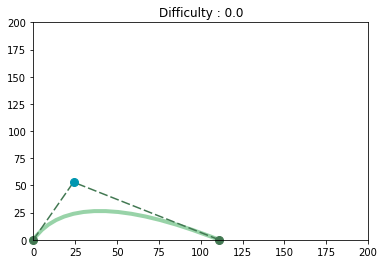

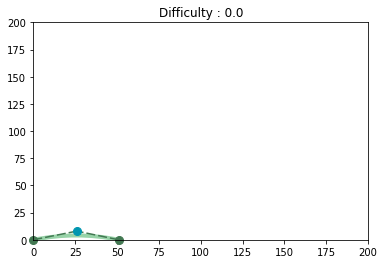

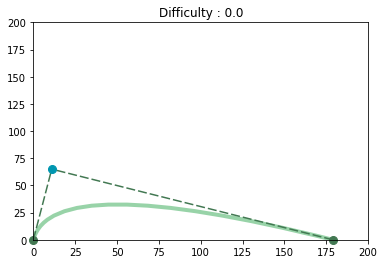

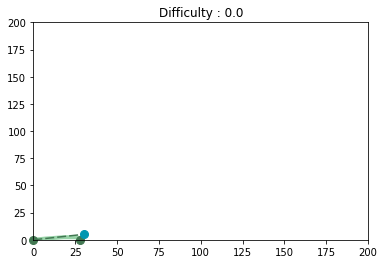

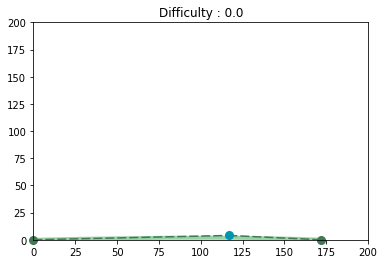

In [88]:
for i in range(5):
    index = np.random.choice(class_0.index)
    row = class_0.loc[[index]].to_numpy()
    point = [np.array([row[0][0], row[0][1]]).astype(int),
            np.array([row[0][2], row[0][3]]).astype(int),
            np.array([row[0][4], row[0][5]]).astype(int)]
    draw(point, row[0][11])

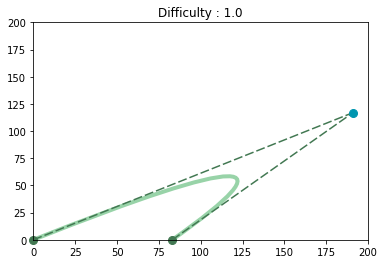

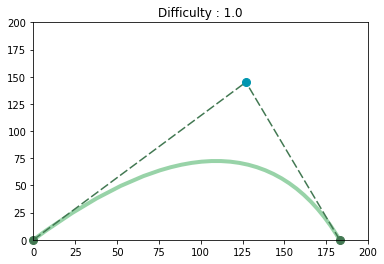

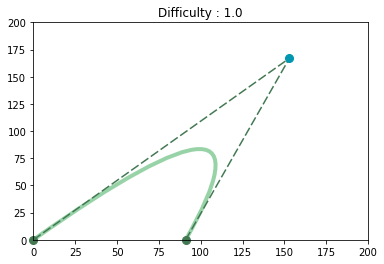

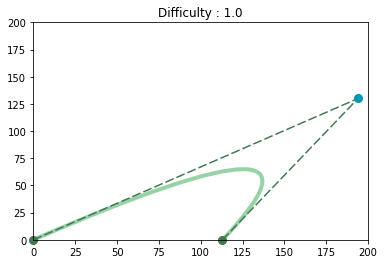

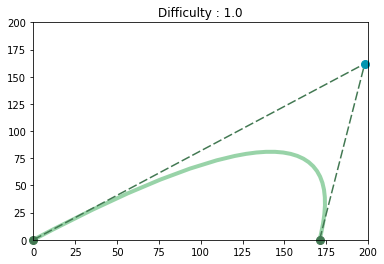

In [89]:
for i in range(5):
    index = np.random.choice(class_1.index)
    row = class_1.loc[[index]].to_numpy()
    point = [np.array([row[0][0], row[0][1]]).astype(int),
            np.array([row[0][2], row[0][3]]).astype(int),
            np.array([row[0][4], row[0][5]]).astype(int)]
    draw(point, row[0][11])

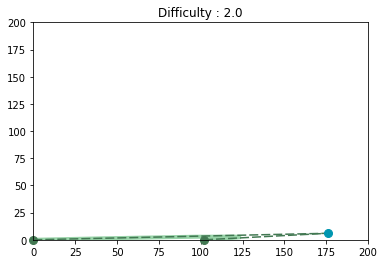

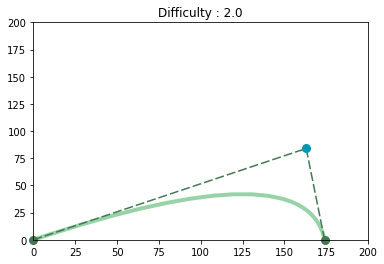

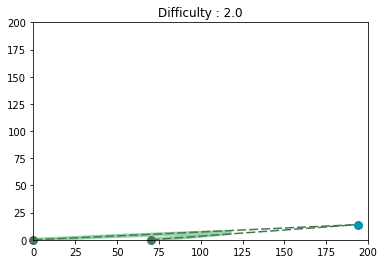

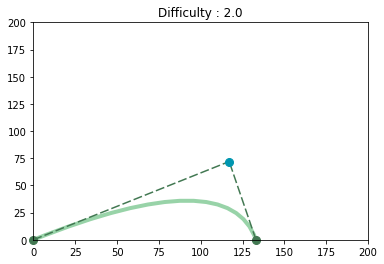

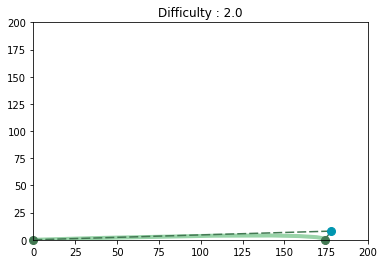

In [90]:
for i in range(5):
    index = np.random.choice(class_2.index)
    row = class_2.loc[[index]].to_numpy()
    point = [np.array([row[0][0], row[0][1]]).astype(int),
            np.array([row[0][2], row[0][3]]).astype(int),
            np.array([row[0][4], row[0][5]]).astype(int)]
    draw(point, row[0][11])

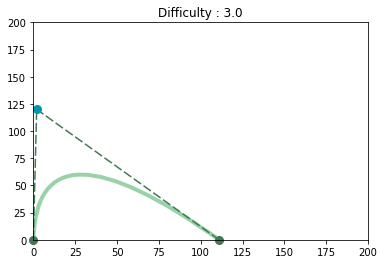

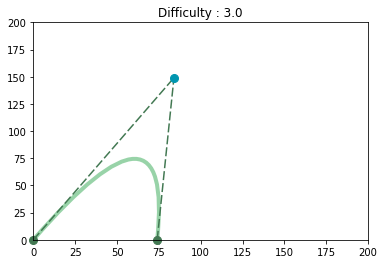

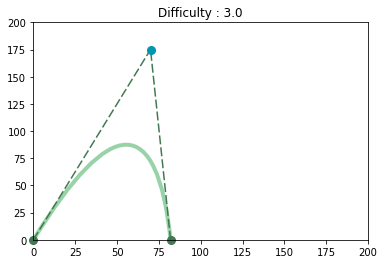

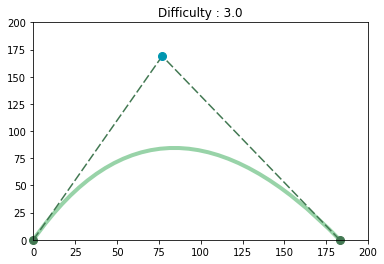

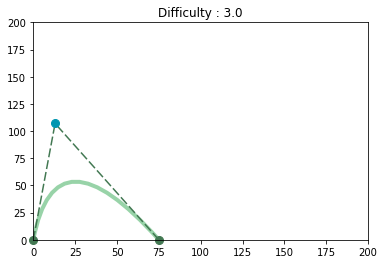

In [91]:
for i in range(5):
    index = np.random.choice(class_3.index)
    row = class_3.loc[[index]].to_numpy()
    point = [np.array([row[0][0], row[0][1]]).astype(int),
            np.array([row[0][2], row[0][3]]).astype(int),
            np.array([row[0][4], row[0][5]]).astype(int)]
    draw(point, row[0][11])

#### Mean shift

In [107]:
from sklearn.cluster import MeanShift

model = MeanShift(bandwidth=48).fit(X)
# model = MeanShift().fit(X)
df["difficulty"] = model.predict(X)
print(df.sample(10))

      x1  y1   x2   y2   x3  y3      angle1     angle2     angle3       dist1  \
3283   0   0   56  132  156   0   60.135404  67.011283  52.853313  143.387587   
1011   0   0   82  121  120   0   51.559816  55.875058  72.565125  146.167712   
3198   0   0   96  124   81   0   30.849378  52.253195  96.897428  156.818366   
911    0   0   37  179  167   0   47.668075  78.321216  54.010710  182.784026   
4885   0   0  173   99  175   0   61.376798  29.780535  88.842667  199.323857   
5125   0   0  162   37  184   0  107.870090  12.865398  59.264512  166.171598   
4739   0   0   12  165  150   0   44.067527  85.840358  50.092115  165.435788   
4416   0   0   61   15  132   0  154.255652  13.815025  11.929322   62.817195   
4977   0   0   16  168  103   0   32.818035  84.559668  62.622297  168.760185   
2621   0   0    3  157   10   0    3.647589  88.905309  87.447102  157.028660   

           dist2  difficulty  
3283  165.601932           2  
1011  126.826653           0  
3198  124.90396

In [108]:
df.describe()

,x1,y1,x2,y2,x3,y3,angle1,angle2,angle3,dist1,dist2,difficulty
count,6000.0,6000.0,6000.000000,6000.000000,6000.000000,6000.0,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.0,0.0,99.747167,99.903167,100.235333,0.0,45.791837,44.948653,89.259510,152.355333,129.336158,1.859667
std,0.0,0.0,56.771919,57.326150,57.593082,0.0,40.163450,23.363851,42.582035,56.804787,54.759012,1.089421
min,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.019137,0.289370,0.316548,3.605551,1.000000,0.000000
25%,0.0,0.0,51.000000,51.000000,50.000000,0.0,13.901787,27.217228,57.889058,112.037939,87.319814,1.000000
50%,0.0,0.0,101.000000,100.000000,101.000000,0.0,37.032972,45.159677,89.693600,158.390340,131.770632,2.000000
75%,0.0,0.0,149.000000,149.000000,149.000000,0.0,64.000155,62.625836,120.042106,194.504499,174.171603,3.000000
max,0.0,0.0,199.000000,199.000000,199.000000,0.0,178.742185,89.707677,179.559272,281.428499,271.543735,3.000000


In [109]:
classes = []
for i in range(df['difficulty'].nunique()):
    classes.append(df[(df["difficulty"] == i)])

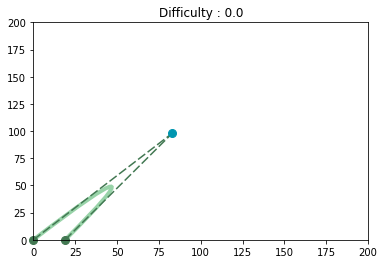

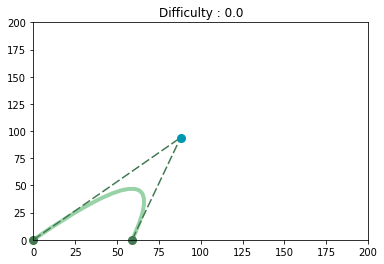

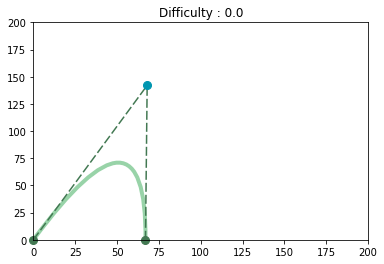

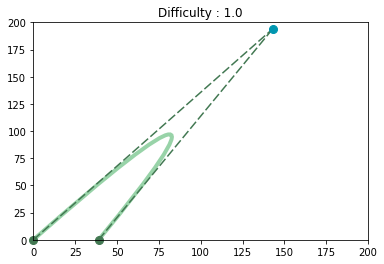

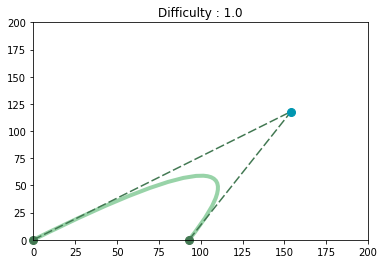

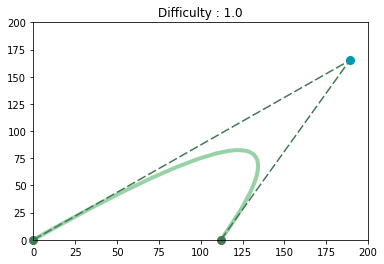

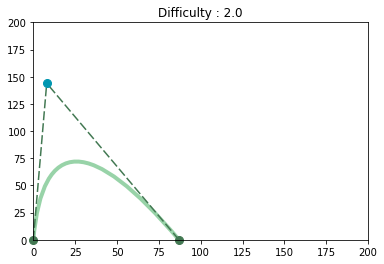

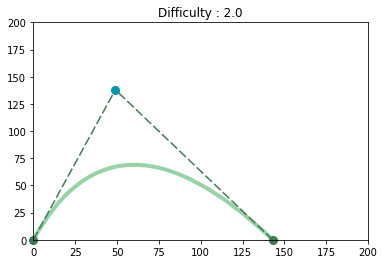

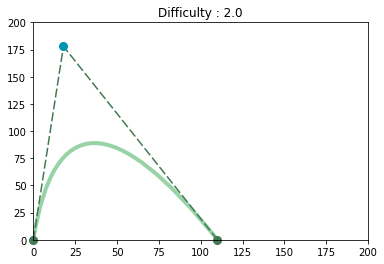

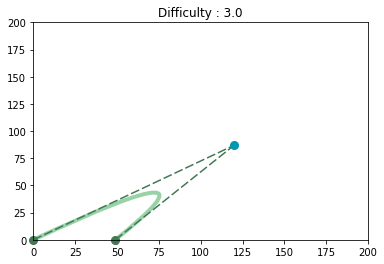

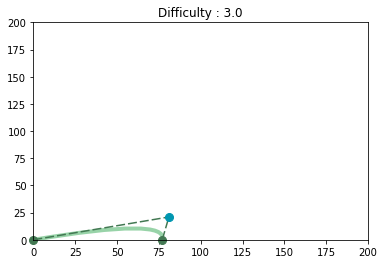

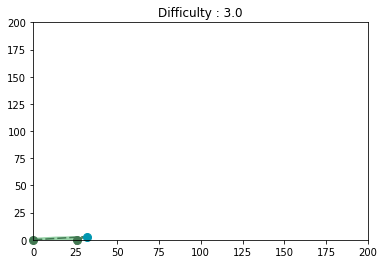

In [110]:
for cl in classes:
    for i in range(3):
        index = np.random.choice(cl.index)
        row = cl.loc[[index]].to_numpy()
        point = [np.array([row[0][0], row[0][1]]).astype(int),
                np.array([row[0][2], row[0][3]]).astype(int),
                np.array([row[0][4], row[0][5]]).astype(int)]
        draw(point, row[0][11])